In [1]:
# Reset pip state — full cleanup + minimal working audio-text dependencies
!pip uninstall -y torch torchaudio transformers accelerate datasets evaluate peft
!pip install -U --no-cache-dir \
  torch==2.2.1 \
  torchaudio==2.2.1 \
  transformers==4.38.2 \
  accelerate==0.27.2 \
  datasets==2.19.0 \
  evaluate==0.4.1 \
  jiwer \
  librosa \
  numpy==1.26.4 \
  peft==0.8.2

Found existing installation: torch 2.2.1
Uninstalling torch-2.2.1:
  Successfully uninstalled torch-2.2.1
Found existing installation: torchaudio 2.2.1
Uninstalling torchaudio-2.2.1:
  Successfully uninstalled torchaudio-2.2.1
Found existing installation: transformers 4.38.2
Uninstalling transformers-4.38.2:
  Successfully uninstalled transformers-4.38.2
Found existing installation: accelerate 0.27.2
Uninstalling accelerate-0.27.2:
  Successfully uninstalled accelerate-0.27.2
Found existing installation: datasets 2.19.0
Uninstalling datasets-2.19.0:
  Successfully uninstalled datasets-2.19.0
Found existing installation: evaluate 0.4.1
Uninstalling evaluate-0.4.1:
  Successfully uninstalled evaluate-0.4.1
Found existing installation: peft 0.8.2
Uninstalling peft-0.8.2:
  Successfully uninstalled peft-0.8.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.7/130.7 kB 771.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.6/755.6 MB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━

In [2]:
import torch
import torchaudio
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC, TrainingArguments, Trainer
from datasets import load_dataset, Audio
import evaluate
import numpy as np
import random
from dataclasses import dataclass
import jiwer
import torchaudio
import matplotlib.pyplot as plt
from torchaudio.transforms import Resample

Loading the dataset

In [3]:

dataset = load_dataset("patrickvonplaten/librispeech_asr_dummy", "clean")
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/datasets/load.py:1486: FutureWarning: The repository for patrickvonplaten/librispeech_asr_dummy contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/patrickvonplaten/librispeech_asr_dummy
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the

Adding processor and preprocessor

In [4]:

processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")

def preprocess(batch):
    audio = batch["audio"]
    batch["input_values"] = processor(audio["array"], sampling_rate=16000).input_values[0]
    batch["labels"] = processor.tokenizer(batch["text"]).input_ids
    return batch

dataset = dataset["validation"].map(preprocess)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/73 [00:00<?, ? examples/s]

Train Test Split

In [5]:

split_dataset = dataset.train_test_split(test_size=0.5, seed=42)
train_ds = split_dataset["train"]
eval_ds = split_dataset["test"]

Data collator class

In [6]:
@dataclass
class DataCollatorCTCWithPadding:
    processor: Wav2Vec2Processor

    def __call__(self, features):
        input_features = [{"input_values": f["input_values"]} for f in features]
        label_features = [{"input_ids": f["labels"]} for f in features]
        batch = self.processor.pad(input_features, padding=True, return_tensors="pt")

        labels_batch = self.processor.tokenizer.pad(label_features, padding=True, return_tensors="pt")
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)
        batch["labels"] = labels
        return batch

Loading the Pretrained Model

In [7]:
model = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-base-960h",
    vocab_size=len(processor.tokenizer),
    pad_token_id=processor.tokenizer.pad_token_id,
    ctc_loss_reduction="mean"
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not

Training Parameters

In [8]:
training_args = TrainingArguments(
    output_dir="./wav2vec2-dummy",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    evaluation_strategy="epoch",
    num_train_epochs=3,
    save_steps=10,
    logging_dir="./logs",
    logging_steps=5,
    report_to=[]
)

Evaluater

In [9]:
def compute_metrics(pred):
    pred_ids = np.argmax(pred.predictions, axis=-1)
    pred_str = processor.batch_decode(pred_ids)
    label_ids = pred.label_ids
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    wer = jiwer.wer(label_str, pred_str)
    return {"wer": wer}

In [10]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    tokenizer=processor,
    data_collator=DataCollatorCTCWithPadding(processor=processor),
    compute_metrics=compute_metrics
)

Training the model and saving

In [11]:
trainer.train()


model.save_pretrained("./wav2vec2-finetuned-dummy")
processor.save_pretrained("./wav2vec2-finetuned-dummy")

Epoch,Training Loss,Validation Loss,Wer
1,0.383000,0.113077,0.146912
2,0.275500,0.105714,0.136895
3,0.130900,0.099124,0.136895


Checkpoint destination directory ./wav2vec2-dummy/checkpoint-10 already exists and is non-empty. Saving will proceed but saved results may be invalid.


[]

**Inference Starts**

Downloaded dummy file from Kaggle harvard.wav
https://www.kaggle.com/datasets/pavanelisetty/sample-audio-files-for-speech-recognition?resource=download

Loading the trained model

In [50]:
model = Wav2Vec2ForCTC.from_pretrained("/content/wav2vec2-finetuned-dummy").to("cuda" if torch.cuda.is_available() else "cpu")
processor = Wav2Vec2Processor.from_pretrained("/content/wav2vec2-finetuned-dummy")

Sampling rate is 16000 in the training

In [56]:
waveform, sample_rate = torchaudio.load("/content/harvard.wav" )
if sample_rate != 16000:
    resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
    waveform = resampler(waveform)

In [57]:
inputs = processor(waveform.squeeze().numpy(), sampling_rate=16000, return_tensors="pt", padding=True)

To see whether the data is present or not

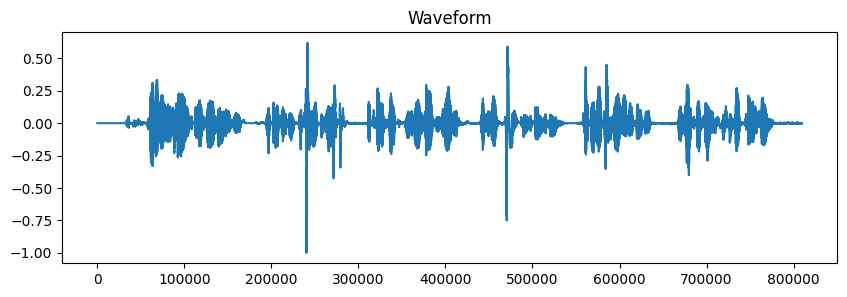

In [58]:


waveform, sample_rate = torchaudio.load("/content/harvard.wav" )
plt.figure(figsize=(10, 3))
plt.plot(waveform[0].numpy())
plt.title("Waveform")
plt.show()

Final Inferencing

In [59]:
with torch.no_grad():
    logits = model(**inputs).logits

pred_ids = torch.argmax(logits, dim=-1)
transcription = processor.batch_decode(pred_ids)[0]

print("Transcription:", transcription)

Transcription: THE STALE SMELL OF OLD BEAR LINGERS IT TAKES HEAT TO BRING OUT THE ODOR A COLD DIP RESTORES HEALTH AN ZEST A SALT PICKLE TASTES FINE WITH HAM TAKKOZAL PASTOR ARE MY FAVORITE A ZESTFUL FOOD IS THE HOT CROSS BUN
